## Data Processing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.api import VAR
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller  


# Step 1: Load and preprocess the data
def load_and_preprocess_data(file_path):
    """
    Load data, convert date, and sort chronologically
    """
    # Load the data
    df = pd.read_csv(file_path)
    
    # Convert Periodo to datetime
    df['Periodo'] = pd.to_datetime(df['Periodo'])

    # Sort by date
    df = df.sort_values('Periodo')
    
    # Set Periodo as index
    df.set_index('Periodo', inplace=True)
    
    # Create 3-month moving average of Core CPI M/M_sa
    df['Core CPI M/M_sa_original'] = df['Core CPI M/M_sa']  # Keep the original for reference
    df['Core CPI M/M_sa'] = df['Core CPI M/M_sa'].rolling(window=3).mean()
    df['M2'] = df['M2'].rolling(window=3).mean()


    # Drop rows with NaN values from the moving average calculation
    df = df.dropna()
    
    return df

# Step 2: Normalize features (X variables)
def normalize_features(df, target_var):
    """
    Normalize all features except the target variable
    """
    # Identify features (all columns except target)
    features = [col for col in df.columns if col != target_var]
    
    # Create a scaler
    scaler = StandardScaler()
    
    # Create a copy of the dataframe
    normalized_df = df.copy()
    
    # Normalize features
    normalized_df[features] = scaler.fit_transform(df[features])
    
    return normalized_df, scaler, features

#Check stationarity and difference non-stationary variables
def check_and_difference_for_stationarity(df, features, target_var, significance_level=0.05):
    """
    Check stationarity of features using Augmented Dickey-Fuller test
    and create differenced series for non-stationary variables
    
    Parameters:
    -----------
    df : pandas DataFrame
        Input data with features
    features : list
        List of feature names to check
    target_var : str
        Name of target variable (won't be differenced)
    significance_level : float
        Significance level for ADF test
        
    Returns:
    --------
    pandas DataFrame with original and differenced features
    dict with stationarity results
    """
    print("\nChecking stationarity of variables...")
    
    # Create a copy of the dataframe to avoid modifying the original
    stationary_df = df.copy()
    
    # Create a dictionary to track stationarity results
    stationarity_results = {}
    
    # List to keep track of the differenced features
    differenced_features = []
    
    # Check each feature for stationarity
    for feature in features:
        # Run Augmented Dickey-Fuller test
        adf_result = adfuller(df[feature].dropna())
        p_value = adf_result[1]
        
        # Determine if stationary
        is_stationary = p_value < significance_level
        
        # Store results
        stationarity_results[feature] = {
            'ADF Statistic': adf_result[0],
            'p-value': p_value,
            'is_stationary': is_stationary,
            'Critical Values': adf_result[4]
        }
        
        # Create differenced series for non-stationary variables
        if not is_stationary:
            print(f"  - {feature} is NOT stationary (p-value: {p_value:.4f}). Creating differenced series.")
            diff_name = f"{feature}_diff"
            stationary_df[diff_name] = df[feature].diff().dropna()
            differenced_features.append(diff_name)
            
            # Verify stationarity of differenced series
            # Skip the first row because of NaN from differencing
            diff_adf_result = adfuller(stationary_df[diff_name].dropna())
            diff_p_value = diff_adf_result[1]
            diff_stationary = diff_p_value < significance_level
            
            stationarity_results[diff_name] = {
                'ADF Statistic': diff_adf_result[0],
                'p-value': diff_p_value,
                'is_stationary': diff_stationary,
                'Critical Values': diff_adf_result[4]
            }
            
            if not diff_stationary:
                print(f"    Warning: {diff_name} is still not stationary (p-value: {diff_p_value:.4f}).")
        else:
            print(f"  - {feature} is stationary (p-value: {p_value:.4f}).")
    
    # Check target variable as well
    adf_result = adfuller(df[target_var].dropna())
    p_value = adf_result[1]
    is_stationary = p_value < significance_level
    
    stationarity_results[target_var] = {
        'ADF Statistic': adf_result[0],
        'p-value': p_value,
        'is_stationary': is_stationary,
        'Critical Values': adf_result[4]
    }
    
    if not is_stationary:
        print(f"  - Target {target_var} is NOT stationary (p-value: {p_value:.4f}).")
        print(f"    Note: Target will be kept as is, but this may affect VAR model validity.")
    else:
        print(f"  - Target {target_var} is stationary (p-value: {p_value:.4f}).")
    
    # Drop rows with NaN values (due to differencing)
    stationary_df = stationary_df.dropna()
    
    # Update features list to include both original stationary and new differenced features
    stationary_features = [f for f in features if stationarity_results[f]['is_stationary']] + differenced_features
    
    
    return stationary_df, stationarity_results, stationary_features

# Step 3: Create expanded feature set
def create_expanded_features(df, features, target_var, max_lag=6, max_ma=3):
    """
    Create lagged features, moving averages, and lagged moving averages
    with special handling for target variable
    """
    # Create a copy of the dataframe
    expanded_df = df.copy()
    
    # Add all variables (features + target) for processing
    all_vars = features + [target_var]
    
    # Create lags for all variables
    for var in all_vars:
        for lag in range(1, max_lag + 1):
            expanded_df[f'{var}_lag{lag}'] = expanded_df[var].shift(lag)
    
    # Create moving averages with different handling for target vs. features
    for var in all_vars:
        for window in range(1, max_ma + 1):
            # Create regular moving average
            ma_col = f'{var}_ma{window}'
            expanded_df[ma_col] = expanded_df[var].rolling(window=window).mean()
            
            # For target variable, we only keep lagged moving averages, not contemporaneous ones
            if var == target_var:
                # Remove the contemporaneous moving average for target variable
                expanded_df = expanded_df.drop(columns=[ma_col])
                
                # Only create lagged moving averages for target variable
                for lag in range(1, max_lag + 1):
                    expanded_df[f'{ma_col}_lag{lag}'] = expanded_df[var].rolling(window=window).mean().shift(lag)
            else:
                # For feature variables, keep both contemporaneous and lagged MAs
                # Create lagged moving averages
                for lag in range(1, max_lag + 1):
                    expanded_df[f'{ma_col}_lag{lag}'] = expanded_df[ma_col].shift(lag)
    
    # Drop rows with NaN values (due to lagged features)
    expanded_df = expanded_df.dropna()
    
    return expanded_df

## LASSO-VAR Model

In [2]:
# Step 4: Implement LASSO-VAR model
class LassoVAR:
    def __init__(self, max_lags=5, cv=5, alphas=None, pre_select=True, max_features=10):
        """
        Initialize LASSO-VAR model
        
        Parameters:
        -----------
        max_lags : int
            Maximum number of lags for VAR model
        cv : int
            Number of cross-validation folds for LASSO
        alphas : list or None
            List of alpha values for LASSO regularization
        pre_select : bool
            Whether to apply pre-selection before VAR fitting
        max_features : int
            Maximum number of features to select with LASSO
        """
        self.max_lags = max_lags
        self.cv = cv
        self.alphas = alphas if alphas is not None else np.logspace(-4, 1, 50)
        self.feature_names = None
        self.pre_select = pre_select
        self.max_features = max_features
        self.var_model = None
        self.optimal_lag = 2  # Default lag if estimation fails
        self.exog_names = None
        
    def fit(self, data):
        """
        Fit LASSO-VAR model to the data
        
        Parameters:
        -----------
        data : pandas DataFrame
            Data with expanded features
        """
        # Store feature names
        self.feature_names = data.columns.tolist()
        
        # If pre-selection is enabled, run LASSO first to select top features
        if self.pre_select:
            print("Running pre-selection to reduce feature space...")
            selected_data = self._pre_select_features(data)
            print(f"Reduced from {len(data.columns)} to {len(selected_data.columns)} features")
            
            # Fit VAR with selected features
            self._fit_var(selected_data)
        else:
            # Fit VAR directly
            self._fit_var(data)
        
        return self
    
    def fit_with_exog(self, data, exog):
        """
        Fit LASSO-VAR model to the data with exogenous variables
        
        Parameters:
        -----------
        data : pandas DataFrame
            Endogenous data with expanded features
        exog : pandas DataFrame
            Exogenous variables data
        """
        # Store feature names
        self.feature_names = data.columns.tolist()
        self.exog_names = exog.columns.tolist()
        
        # If pre-selection is enabled, run LASSO first to select top features
        if self.pre_select:
            print("Running pre-selection to reduce feature space...")
            selected_data = self._pre_select_features(data)
            print(f"Reduced from {len(data.columns)} to {len(selected_data.columns)} features")
            
            # Make sure exog data aligns with selected_data index
            aligned_exog = exog.loc[exog.index.isin(selected_data.index)]
            self._fit_var(selected_data, exog_data=aligned_exog)
        else:
            # Fit VAR directly with exogenous variables
            self._fit_var(data, exog_data=exog)
        
        return self
    
    def _pre_select_features(self, data):
        """
        Use LASSO to pre-select top features for target variable
        """
        # Focus on our main target variable
        target_var = 'Core CPI M/M_sa'
        target_idx = self.feature_names.index(target_var)
        
        # Get target and features
        y = data[target_var].values
        
        # Create a version of the data without the contemporaneous target
        # This ensures we don't introduce look-ahead bias
        X_cols = [col for col in data.columns if col != target_var]
        
        # Further filter to ensure no contemporaneous variables of the target are used
        # (like original versions without lags)
        X_cols = [col for col in X_cols if not (col.startswith(target_var.split('_')[0]) and '_lag' not in col and '_ma' not in col)]
        
        X = data[X_cols]
        
        # Create TimeSeriesSplit for cross-validation
        tscv = TimeSeriesSplit(n_splits=self.cv)
        
        # Create LassoCV model for feature selection
        lasso = LassoCV(
            alphas=self.alphas,
            cv=tscv,
            max_iter=10000,
            selection='random',
            random_state=42,
            fit_intercept=True
        )
        
        # Fit the model
        lasso.fit(X, y)
        
        # Get feature importance
        importance = pd.DataFrame({
            'feature': X.columns,
            'coefficient': lasso.coef_
        })
        importance['abs_coef'] = importance['coefficient'].abs()
        importance = importance.sort_values('abs_coef', ascending=False)
        
        # Identify autoregressive terms (properly lagged)
        auto_terms = [col for col in X.columns if col.startswith(f"{target_var}_")]
        
        # Sort autoregressive terms by importance
        auto_importance = importance[importance['feature'].isin(auto_terms)]
        
        # Select top autoregressive terms
        top_auto_terms = []
        if len(auto_importance) > 0:
            top_auto_terms = auto_importance.head(5)['feature'].tolist()
            print(f"Top autoregressive terms: {', '.join(top_auto_terms)}")
        else:
            print("No autoregressive terms selected")
        
        # Select other top important features (excluding autoregressive terms)
        other_features = importance[~importance['feature'].isin(auto_terms)]
        top_other_features = other_features.head(self.max_features - len(top_auto_terms))['feature'].tolist()
        
        # Combine top autoregressive terms and other features
        top_features = top_auto_terms + top_other_features
        
        # Add the target variable and top features
        selected_features = [target_var] + top_features
        
        # Create reduced dataset
        selected_data = data[selected_features]
        
        print(f"Total features selected: {len(selected_features)}")
        print(f"Top features: {', '.join(top_features[:5])} ...")
        
        return selected_data
    
    def _fit_var(self, data, exog_data=None):
        """
        Fit VAR model to the selected data
        """
        # Set up the VAR model
        if exog_data is not None:
            # Ensure perfect index alignment by reindexing
            common_indices = data.index.intersection(exog_data.index)
            if len(common_indices) < len(data):
                print(f"Warning: Dropping {len(data) - len(common_indices)} observations due to missing exogenous data")
                
            # Reindex both datasets to the common indices
            aligned_data = data.loc[common_indices]
            aligned_exog = exog_data.loc[common_indices]
            
            model = VAR(aligned_data, exog=aligned_exog)
            print(f"Using {aligned_exog.shape[1]} exogenous variables in VAR model")
        else:
            model = VAR(data)
        
        # Try to estimate optimal lag length
        try:
            # Get lag order information for 1 to max_lags
            lag_results = {}
            for lag in range(1, min(self.max_lags, len(data) // len(data.columns) // 3) + 1):
                try:
                    results = model.fit(lag)
                    lag_results[lag] = {
                        'aic': results.aic,
                        'bic': results.bic
                    }
                except:
                    # Skip lags that cause estimation problems
                    continue
            
            # Select optimal lag based on AIC if we have results
            if lag_results:
                self.optimal_lag = min(lag_results, key=lambda x: lag_results[x]['aic'])
            else:
                self.optimal_lag = 1  # Default to lag 1 if estimation fails
        except:
            # Default to lag 1 if optimal lag estimation fails
            self.optimal_lag = 1
        
        print(f"Selected optimal lag: {self.optimal_lag}")
        
        # Fit VAR model with selected lag
        self.var_model = model.fit(self.optimal_lag)
        
        return self
    
    def predict(self, data, steps=1):
        """
        Predict using LASSO-VAR model
        
        Parameters:
        -----------
        data : pandas DataFrame
            Latest data for prediction
        steps : int
            Number of steps to forecast
        
        Returns:
        --------
        pandas DataFrame with forecasts
        """
        # Use VAR model for forecasting
        forecasts = self._predict_var(data, steps=steps)
        
        return forecasts
    
    def predict_with_exog(self, data, exog, future_exog, steps=1):
        """
        Predict using LASSO-VAR model with exogenous variables
        
        Parameters:
        -----------
        data : pandas DataFrame
            Latest endogenous data for prediction
        exog : pandas DataFrame
            Historical exogenous data
        future_exog : pandas DataFrame or numpy array
            Future values of exogenous variables for forecast period
        steps : int
            Number of steps to forecast
            
        Returns:
        --------
        pandas DataFrame with forecasts
        """
        # Use VAR model for forecasting with exogenous variables
        forecasts = self._predict_var(data, exog_data=exog, future_exog=future_exog, steps=steps)
        
        return forecasts
    
    def _predict_var(self, data, exog_data=None, future_exog=None, steps=1):
        """
        Predict using VAR model with optional exogenous variables
        """
        # Extract only the columns that were used in the VAR model
        var_columns = self.var_model.names
        
        # Make sure we have all the columns needed
        if not all(col in data.columns for col in var_columns):
            missing = [col for col in var_columns if col not in data.columns]
            raise ValueError(f"Missing columns in input data: {missing}")
        
        # Use only the columns that were included in the VAR model
        input_data = data[var_columns].values[-self.optimal_lag:]
        
        # Generate forecasts using VAR model
        if future_exog is not None:
            var_forecast = self.var_model.forecast(input_data, steps=steps, exog_future=future_exog.values)
        else:
            var_forecast = self.var_model.forecast(input_data, steps=steps)
        
        # Create dataframe for results
        dates = [data.index[-1] + timedelta(days=30 * (i+1)) for i in range(steps)]
        forecasts = pd.DataFrame(var_forecast, index=dates, columns=var_columns)
        
        return forecasts
    
    def generate_future_exog(self, last_exog_values, steps, growth_rates):
        """
        Generate future exogenous variable values based on growth rates
        
        Parameters:
        -----------
        last_exog_values : pandas Series or numpy array
            Last observed values of exogenous variables
        steps : int
            Number of future steps to generate
        growth_rates : dict or float
            Monthly growth rates for each exogenous variable,
            either a single float for all variables or a dict mapping
            variable names to growth rates
            
        Returns:
        --------
        pandas DataFrame with future exogenous values
        """
        if isinstance(last_exog_values, pd.Series):
            var_names = last_exog_values.index.tolist()
            last_values = last_exog_values.values
        elif isinstance(last_exog_values, pd.DataFrame):
            var_names = last_exog_values.columns.tolist()
            last_values = last_exog_values.iloc[-1].values
        else:
            # Assume numpy array
            if hasattr(self, 'exog_names'):
                var_names = self.exog_names
            else:
                var_names = [f"Exog_{i}" for i in range(len(last_exog_values))]
            last_values = last_exog_values
        
        # Initialize array for future values
        future_values = np.zeros((steps, len(var_names)))
        
        # Generate future values for each variable
        for i, var_name in enumerate(var_names):
            # Get growth rate for this variable
            if isinstance(growth_rates, dict) and var_name in growth_rates:
                growth = growth_rates[var_name]
            elif isinstance(growth_rates, (int, float)):
                growth = growth_rates
            else:
                growth = 0.0  # Default to no growth
                
            # First step
            future_values[0, i] = last_values[i] * (1 + growth)
            
            # Subsequent steps
            for step in range(1, steps):
                future_values[step, i] = future_values[step-1, i] * (1 + growth)
        
        # Create DataFrame with appropriate column names
        future_exog = pd.DataFrame(future_values, columns=var_names)
        
        return future_exog
    
    def get_feature_importance(self, variable):
        """
        Get feature importance for a specific variable
        
        Parameters:
        -----------
        variable : str
            Name of the variable
            
        Returns:
        --------
        DataFrame with feature importance
        """
        # Check if we have VAR model
        if self.var_model is not None:
            return self._get_var_importance(variable)
        else:
            raise ValueError(f"No model available for variable {variable}")
        
    def _get_var_importance(self, variable):
        """
        Get feature importance from VAR model
        """
        print("\nDEBUG - VAR Feature Importance Analysis:")
        print(f"Variable: {variable}")
        
        try:
            # Get the variable index
            if variable in self.feature_names:
                var_idx = self.feature_names.index(variable)
                print(f"Variable index: {var_idx}")
            else:
                print(f"Variable {variable} not found in feature_names")
                # Return empty DataFrame if variable not found
                return pd.DataFrame(columns=['feature', 'coefficient', 'abs_coef'])
            
            # Get coefficients from VAR model
            if hasattr(self.var_model, 'coefs'):
                coefs = self.var_model.coefs
                print(f"VAR coefficient shape: {coefs.shape}")
            else:
                print("VAR model does not have coefs attribute")
                # Return empty DataFrame if no coefficients
                return pd.DataFrame(columns=['feature', 'coefficient', 'abs_coef'])
            
            # Flatten coefficients for this variable
            var_coefs = coefs[:, var_idx, :].flatten()
            print(f"Flattened coefficients length: {len(var_coefs)}")
            
            # Create feature names
            features = []
            for lag in range(1, self.optimal_lag + 1):
                for var in self.feature_names:
                    features.append(f"{var}_lag{lag}")
            
            print(f"Generated feature names length: {len(features)}")
            
            # Ensure matching lengths
            if len(features) != len(var_coefs):
                print(f"Length mismatch: features {len(features)}, coefficients {len(var_coefs)}")
                # Adjust lengths to match
                min_len = min(len(features), len(var_coefs))
                features = features[:min_len]
                var_coefs = var_coefs[:min_len]
                print(f"Adjusted to matching length: {min_len}")
            
            # Create importance dataframe
            importance = pd.DataFrame({
                'feature': features,
                'coefficient': var_coefs
            })
            
            # Sort by absolute value
            importance['abs_coef'] = importance['coefficient'].abs()
            importance = importance.sort_values('abs_coef', ascending=False)
            
            return importance.reset_index(drop=True)
            
        except Exception as e:
            print(f"Error in VAR importance analysis: {str(e)}")
            # Return empty DataFrame if any error
            return pd.DataFrame(columns=['feature', 'coefficient', 'abs_coef'])

In [3]:
# Step 5: Evaluate forecast accuracy
def evaluate_forecast(model, test_data, target_var, exog_data=None, future_exog=None, h=3):
    """
    Evaluate forecast accuracy for different horizons
    
    Parameters:
    -----------
    model : trained model
        Fitted LassoVAR model
    test_data : pandas DataFrame
        Test data for evaluation
    target_var : str
        Target variable name
    exog_data : pandas DataFrame
        Historical exogenous data
    future_exog : pandas DataFrame
        Future exogenous data for the test period
    h : int
        Maximum forecast horizon
    
    Returns:
    --------
    DataFrame with evaluation metrics
    """
    results = []
    
    # Only proceed if we have enough test data points
    if len(test_data) <= h:
        print(f"Warning: Not enough test data points ({len(test_data)}) for horizon {h}")
        # Return empty metrics
        metrics = pd.DataFrame({
            'ME': [np.nan] * h,
            'SD': [np.nan] * h,
            'MAE': [np.nan] * h,
            'MSE': [np.nan] * h,
            'RMSE': [np.nan] * h,
        }, index=pd.Index(range(1, h+1), name='horizon'))
        return metrics, pd.DataFrame(columns=['horizon', 'actual', 'forecast', 'error', 'abs_error', 'squared_error'])
    
    # Number of evaluation points
    n_eval = max(1, len(test_data) - h)
    
    # For each test point, make a forecast and evaluate
    for i in range(n_eval):
        try:
            # Data available at this point
            available_data = test_data.iloc[:i+1]
            
            # Exogenous data available up to this point (if provided)
            if exog_data is not None and future_exog is not None:
                # Use exogenous data for this forecast period
                available_exog = exog_data.loc[exog_data.index <= available_data.index[-1]]
                
                # Get future exogenous data for the forecast horizon
                future_exog_horizon = future_exog.iloc[:min(h, len(future_exog)-i)]
                
                # Forecast next h periods with exogenous variables
                forecast = model.predict_with_exog(available_data, exog=available_exog, 
                                                 future_exog=future_exog_horizon, steps=h)
            else:
                # Standard forecast without exogenous variables
                forecast = model.predict(available_data, steps=h)
            
            # Actual values for comparison (only up to available test data)
            max_j = min(h, len(test_data) - (i+1))
            actuals = test_data.iloc[i+1:i+1+max_j][target_var].values
            
            # Forecasted values
            if target_var in forecast.columns:
                preds = forecast[target_var].values[:max_j]
            else:
                # If the model only predicted the target variable
                preds = forecast.values.flatten()[:max_j]
            
            # Calculate errors for each horizon
            for j in range(len(actuals)):
                results.append({
                    'horizon': j+1,
                    'actual': actuals[j],
                    'forecast': preds[j],
                    'error': actuals[j] - preds[j],
                    'abs_error': abs(actuals[j] - preds[j]),
                    'squared_error': (actuals[j] - preds[j])**2
                })
        except Exception as e:
            print(f"Error in evaluation at point {i}: {str(e)}")
            continue
    
    # If we have no results, return empty metrics
    if not results:
        print("Warning: No forecast evaluation results available")
        # Return empty metrics
        metrics = pd.DataFrame({
            'ME': [np.nan] * h,
            'SD': [np.nan] * h,
            'MAE': [np.nan] * h,
            'MSE': [np.nan] * h,
            'RMSE': [np.nan] * h,
        }, index=pd.Index(range(1, h+1), name='horizon'))
        return metrics, pd.DataFrame(columns=['horizon', 'actual', 'forecast', 'error', 'abs_error', 'squared_error'])
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate metrics by horizon
    metrics = results_df.groupby('horizon').agg({
        'error': ['mean', 'std'],
        'abs_error': 'mean',
        'squared_error': 'mean'
    })
    
    # Rename columns
    metrics.columns = ['ME', 'SD', 'MAE', 'MSE']
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    
    return metrics, results_df

def plot_forecasts(model, data, exog_data=None, target_var='Core CPI M/M_sa', forecast_periods=3, oil_growth_rate=0.03):
    """
    Plot historical data and forecasts using fixed train-test split
    with half-bias correction applied to all forecasts
    
    Parameters:
    -----------
    model : LassoVAR model
        The model to use for forecasting
    data : pandas DataFrame
        Data with expanded features
    exog_data : pandas DataFrame, optional
        Exogenous data (e.g., oil prices)
    target_var : str
        Target variable name
    forecast_periods : int
        Number of periods to forecast into the future
    oil_growth_rate : float
        Monthly growth rate for oil prices (if using exogenous)
    """
    # Fixed 90/10 train-test split
    train_size = 0.9
    train_idx = int(len(data) * train_size)
    train_data = data.iloc[:train_idx]
    test_data = data.iloc[train_idx:]
    
    print(f"Training data: {len(train_data)} observations ({train_size*100:.0f}%)")
    print(f"Test data: {len(test_data)} observations ({(1-train_size)*100:.0f}%)")
    
    # Handle exogenous data if provided
    if exog_data is not None:
        # Split exogenous data and ensure index alignment with train/test data
        train_exog = exog_data.loc[exog_data.index.isin(train_data.index)].copy()
        test_exog = exog_data.loc[exog_data.index.isin(test_data.index)].copy()
        
        # Make sure we have matching indices
        if len(train_exog) != len(train_data):
            print(f"Warning: Training data ({len(train_data)}) and exogenous data ({len(train_exog)}) have different lengths")
            # Get common indices
            common_indices = train_data.index.intersection(train_exog.index)
            print(f"Using {len(common_indices)} common dates for training")
            
            # Restrict data to common indices
            train_data = train_data.loc[common_indices]
            train_exog = train_exog.loc[common_indices]
            
        # Ensure perfect alignment by reindexing
        train_exog = train_exog.reindex(train_data.index)
        
        # Fit model with exogenous variables
        try:
            model.fit_with_exog(train_data, train_exog)
        except Exception as e:
            print(f"Error fitting model with exogenous variables: {str(e)}")
            print("Falling back to standard fit without exogenous variables")
            model.fit(train_data)
            exog_data = None
            train_exog = None
            test_exog = None
        
        if exog_data is not None:  # Continue only if we didn't fallback
            # Get last observed exogenous value for generating future values
            last_exog_value = train_exog.iloc[-1]
            
            # Generate future exogenous values for test period
            future_test_exog = model.generate_future_exog(
                last_exog_value,
                steps=len(test_data),
                growth_rates=oil_growth_rate
            )
            
            # Generate future exogenous values for future forecasts
            last_full_exog = exog_data.iloc[-1]
            future_exog = model.generate_future_exog(
                last_full_exog,
                steps=forecast_periods,
                growth_rates=oil_growth_rate
            )
            
            # Print oil price scenario for transparency
            oil_col = exog_data.columns[0]
            print(f"\nLast observed {oil_col}: {last_full_exog.iloc[0]:.2f}")
            print(f"{oil_col} scenario ({oil_growth_rate*100:.1f}% monthly growth):")
            for i, price in enumerate(future_exog.iloc[:, 0].values):
                print(f"  Month {i+1}: {price:.2f}")
            
            # Make forecasts with exogenous variables
            try:
                forecasts = model.predict_with_exog(
                    train_data,
                    exog=train_exog,
                    future_exog=future_test_exog,
                    steps=len(test_data)
                )
                
                # Make future forecasts with exogenous variables
                future_forecasts = model.predict_with_exog(
                    data,
                    exog=exog_data,
                    future_exog=future_exog,
                    steps=forecast_periods
                )
            except Exception as e:
                print(f"Error in forecasting with exogenous variables: {str(e)}")
                print("Falling back to standard forecasts")
                forecasts = model.predict(train_data, steps=len(test_data))
                future_forecasts = model.predict(data, steps=forecast_periods)
                exog_data = None  # Disable exogenous plotting
        else:
            # Standard forecasting (after fallback)
            forecasts = model.predict(train_data, steps=len(test_data))
            future_forecasts = model.predict(data, steps=forecast_periods)
    else:
        # Standard fitting and forecasting without exogenous variables
        model.fit(train_data)
        forecasts = model.predict(train_data, steps=len(test_data))
        future_forecasts = model.predict(data, steps=forecast_periods)
    
    # Ensure test_data and forecasts are aligned
    if len(forecasts) > len(test_data):
        forecasts = forecasts.iloc[:len(test_data)]
    elif len(forecasts) < len(test_data):
        # If we have fewer forecasts than test points, pad with NaN
        missing_dates = test_data.index[len(forecasts):]
        missing_df = pd.DataFrame(index=missing_dates, columns=forecasts.columns)
        forecasts = pd.concat([forecasts, missing_df])
    
    # Calculate bias from test forecasts (using only available values)
    valid_mask = ~np.isnan(forecasts[target_var].values) & ~np.isnan(test_data[target_var].values)
    if np.any(valid_mask):
        forecast_values = forecasts[target_var].values[valid_mask]
        actual_values = test_data[target_var].values[valid_mask]
        full_bias = np.mean(forecast_values - actual_values)
        
        # Apply bias correction 
        half_bias = full_bias / 1.5  
        print(f"\nDetected forecast bias: {full_bias:.4f}")
        print(f"Applying half-bias correction: {half_bias:.4f}")
        
        # Apply half-bias correction to forecasts and future forecasts
        forecasts[target_var] = forecasts[target_var] - half_bias
        future_forecasts[target_var] = future_forecasts[target_var] - half_bias
    else:
        print("\nWarning: Could not calculate bias correction (no valid forecast-actual pairs)")
    
    # Plot results
    plt.figure(figsize=(12, 6))
    
    # Plot training data
    plt.plot(train_data.index, train_data[target_var], 'b-', label='Training Data')
    
    # Plot test data
    plt.plot(test_data.index, test_data[target_var], 'g-', label='Test Data')
    
    # Plot half-bias-corrected forecasts on test data
    valid_forecast_mask = ~np.isnan(forecasts[target_var].values)
    if np.any(valid_forecast_mask):
        valid_indices = test_data.index[valid_forecast_mask]
        valid_values = forecasts[target_var].values[valid_forecast_mask]
        plt.plot(valid_indices, valid_values, 'r--', label='In-Sample Forecasts')
    
    # Plot half-bias-corrected future forecasts
    plt.plot(future_forecasts.index, future_forecasts[target_var], 
             'purple', marker='o', label='Future Forecasts')
    
    
    plt.legend(loc='best')
    plt.title(f'LASSO-VAR Forecast for {target_var} (3mma)')
    plt.xlabel('Date')
    plt.ylabel(target_var)
    plt.grid(True)
    plt.tight_layout()
    
    # Calculate evaluation metrics
    try:
        if exog_data is not None and 'train_exog' in locals() and 'future_test_exog' in locals():
            metrics, _ = evaluate_forecast(model, test_data, target_var, 
                                          exog_data=train_exog, future_exog=future_test_exog, h=3)
        else:
            metrics, _ = evaluate_forecast(model, test_data, target_var, h=3)
        
        print("\nForecast Evaluation Metrics by Horizon:")
        print(metrics)
    except Exception as e:
        print(f"\nError calculating evaluation metrics: {str(e)}")
        metrics = pd.DataFrame()
    
    print("\nHalf-Bias-Corrected Future Forecasts:")
    print(future_forecasts[target_var])
    
    return future_forecasts, metrics, train_data, test_data

def analyze_feature_importance(model, target_var, top_n=15):
    """
    Analyze and visualize feature importance for target variable
    
    Parameters:
    -----------
    model : trained model
        Fitted LassoVAR model
    target_var : str
        Target variable name
    top_n : int
        Number of top features to display
    """
    try:
        # Get feature importance
        importance = model.get_feature_importance(target_var)
        
        # Check if we have any features
        if importance.empty:
            print("No significant features found.")
            return pd.DataFrame()
        
        # Take top N features (or fewer if we don't have that many)
        top_n = min(top_n, len(importance))
        top_features = importance.head(top_n)
        
        # Plot
        plt.figure(figsize=(12, 8))
        plt.barh(top_features['feature'], top_features['coefficient'])
        plt.title(f'Top {top_n} Important Features for {target_var} (3mma)')
        plt.xlabel('Coefficient Value')
        plt.ylabel('Feature')
        plt.grid(True, axis='x')
        plt.tight_layout()
        
        return importance
    
    except Exception as e:
        print(f"Error analyzing feature importance: {str(e)}")
        print("Skipping feature importance analysis.")
        return pd.DataFrame()  # Return empty DataFrame

def decompose_forecast_error(model, train_data, test_data, target_var='Core CPI M/M_sa'):
    """
    Decompose forecast errors into two components for the test sample:
    1. Error due to wrongly predicted X variables in the VAR
    2. Residual error from the model itself
    
    Parameters:
    -----------
    model : LassoVAR model
        Fitted model to analyze
    train_data : pandas DataFrame
        Training data used to fit the model
    test_data : pandas DataFrame
        Test data to evaluate (contains both actual values and model predictions)
    target_var : str
        Target variable to analyze
        
    Returns:
    --------
    DataFrame with decomposed errors
    """
    
    # Ensure we have a VAR model
    if model.var_model is None:
        print("No VAR model found. Please fit the model first.")
        return None
    
    # Get the variables in the VAR model
    var_columns = model.var_model.names
    
    # Get the index of the target variable
    if target_var in var_columns:
        target_idx = var_columns.index(target_var)
    else:
        print(f"Target variable {target_var} not found in VAR model.")
        return None
    
    # Get VAR coefficients for analysis
    coeffs = model.var_model.coefs
    target_coeffs = coeffs[:, target_idx, :]
    
    # Initialize results
    results = []
    
    # Get actual and predicted values from test data
    for i in range(len(test_data) - 1):
        try:
            # Current and next data points
            current_data = test_data.iloc[i:i+1]
            next_data = test_data.iloc[i+1:i+2]
            
            # Actual value for next period
            actual_value = next_data[target_var].values[0]
            
            # Use the model to calculate what would have been predicted
            # Get lagged values (use as many as available up to optimal_lag)
            available_lags = min(i + 1, model.optimal_lag)
            if available_lags < model.optimal_lag:
                # Skip if not enough lags are available
                continue
                
            # Get previous values as inputs to VAR equation
            input_values = []
            for lag in range(1, available_lags + 1):
                if i - lag + 1 >= 0:  # Make sure index is valid
                    input_values.append(test_data.iloc[i-lag+1][var_columns].values)
                else:
                    # Not enough history
                    continue
            
            # Reverse order so lag 1 is first, lag 2 is second, etc.
            input_values.reverse()
            
            # Manually calculate VAR prediction using coefficients
            prediction = model.var_model.intercept.copy()
            for lag in range(min(len(input_values), model.optimal_lag)):
                prediction += np.dot(coeffs[lag], input_values[lag])
            
            # Extract predicted value for target
            predicted_value = prediction[target_idx]
            
            # Now calculate what prediction would be with perfect X values
            # We'll use actual X values from next period but keep target as predicted
            perfect_x_adjustment = 0
            
            # For each X variable, calculate impact of using actual vs predicted value
            for j, col in enumerate(var_columns):
                if col != target_var:  # Skip target variable itself
                    # Difference between actual next X and predicted next X
                    x_diff = next_data[col].values[0] - prediction[j]
                    
                    # Impact on target using first lag coefficient (approximation)
                    perfect_x_adjustment += x_diff * target_coeffs[0, j]
            
            # Perfect X forecast would correct this X prediction error
            perfect_x_forecast = predicted_value + perfect_x_adjustment
            
            # Calculate errors
            total_error = actual_value - predicted_value
            x_prediction_error = predicted_value - perfect_x_forecast
            model_residual_error = actual_value - perfect_x_forecast
            
            # Store results
            results.append({
                'date': next_data.index[0],
                'actual': actual_value,
                'predicted': predicted_value,
                'perfect_x_forecast': perfect_x_forecast,
                'total_error': total_error,
                'x_prediction_error': x_prediction_error,
                'model_residual_error': model_residual_error,
                'x_error_pct': (x_prediction_error / total_error) * 100 if total_error != 0 else 0,
                'model_error_pct': (model_residual_error / total_error) * 100 if total_error != 0 else 0
            })
            
        except Exception as e:
            print(f"Error analyzing test point {i}: {str(e)}")
            continue
    
    # Convert to DataFrame
    if results:
        results_df = pd.DataFrame(results).set_index('date')
        
        # Calculate summary statistics
        total_abs_error = results_df['total_error'].abs().sum()
        x_abs_error = results_df['x_prediction_error'].abs().sum()
        model_abs_error = results_df['model_residual_error'].abs().sum()
        
        
        # Plot error decomposition
        plt.figure(figsize=(14, 8))
        
        # Plot actual vs predicted vs perfect X
        plt.subplot(2, 1, 1)
        plt.plot(results_df.index, results_df['actual'], 'b-', label='Actual')
        plt.plot(results_df.index, results_df['predicted'], 'r--', label='Predicted')
        plt.plot(results_df.index, results_df['perfect_x_forecast'], 'g-.', label='With Perfect X')
        plt.title(f'{target_var} - Test Sample Values')
        plt.legend()
        plt.grid(True)
        
        
        plt.subplot(2, 1, 2)
        # Create stacked bar chart with percentages
        dates = results_df.index
        x_pcts = results_df['x_error_pct'].abs()
        model_pcts = results_df['model_error_pct'].abs()

        # Normalize for stacking
        bars = []
        for i, date in enumerate(dates):
            # Only include points with meaningful errors
            if x_pcts.iloc[i] + model_pcts.iloc[i] > 0:
                bars.append({
                    'date': date,
                    'X Error': x_pcts.iloc[i],
                    'Model Error': model_pcts.iloc[i]
                })

        if bars:
            bars_df = pd.DataFrame(bars).set_index('date')
            ax = bars_df.plot(kind='bar', stacked=True, ax=plt.gca(), 
                        color=['red', 'blue'])
            
            # Format the x-axis labels to show only month and year
            # Get the current tick labels
            labels = [item.get_text() for item in ax.get_xticklabels()]
            
            # Convert each datetime string to a more readable format (Month-Year)
            new_labels = []
            for label in labels:
                try:
                    # Parse the date from the label text
                    date = pd.to_datetime(label)
                    # Format as Month-Year
                    new_label = date.strftime('%b-%Y')
                    new_labels.append(new_label)
                except:
                    # Keep original if parsing fails
                    new_labels.append(label)
            
            # Set the new labels
            ax.set_xticklabels(new_labels, rotation=45)
            
            plt.title('Error Composition - Percentage of Total Error')
            plt.ylabel('Percent of Total Error')
            plt.ylim(0, 100)
            plt.grid(True, axis='y')

        plt.tight_layout()
        plt.show()
        
        return results_df
    else:
        print("No results available for error decomposition.")
        return None

Loaded data with shape: (130, 24)
Extracted Oil Price as exogenous variable
Normalized 22 features
Normalized Oil Price exogenous variable

Checking stationarity of variables...
  - USD/CLP is stationary (p-value: 0.0000).
  - 11 month expected MPR is NOT stationary (p-value: 0.1768). Creating differenced series.
  - Ex-Ante Real Rate is NOT stationary (p-value: 0.1070). Creating differenced series.
  - M1 is NOT stationary (p-value: 0.1900). Creating differenced series.
  - M2 is stationary (p-value: 0.0080).
  - REER is stationary (p-value: 0.0000).
  - Overall PPI_sa is stationary (p-value: 0.0054).
  - Manufacturing PPI_sa is stationary (p-value: 0.0128).
  - Mining PPI_sa is stationary (p-value: 0.0000).
  - Utilities PPI_sa is stationary (p-value: 0.0000).
  - Agri PPI_sa is stationary (p-value: 0.0000).
  - IMACEC Total_sa is stationary (p-value: 0.0040).
  - IMACEC Production of Goods_sa is stationary (p-value: 0.0000).
  - IMACEC Commerce_sa is stationary (p-value: 0.0000).
  

/var/folders/7m/ls9fd7f54kq_8_64h69bskkr0000gn/T/ipykernel_16915/1037870379.py:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  expanded_df[f'{var}_lag{lag}'] = expanded_df[var].shift(lag)
/var/folders/7m/ls9fd7f54kq_8_64h69bskkr0000gn/T/ipykernel_16915/1037870379.py:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  expanded_df[f'{var}_lag{lag}'] = expanded_df[var].shift(lag)
/var/folders/7m/ls9fd7f54kq_8_64h69bskkr0000gn/T/ipykernel_16915/1037870379.py:180: PerformanceWarning: DataFrame is highly fragmented.  This is usually

Running pre-selection to reduce feature space...
Top autoregressive terms: Core CPI M/M_sa_lag1, Core CPI M/M_sa_ma1_lag1, Core CPI M/M_sa_ma2_lag1, Core CPI M/M_sa_original_diff_ma3, Core CPI M/M_sa_original_diff_ma2
Total features selected: 11
Top features: Core CPI M/M_sa_lag1, Core CPI M/M_sa_ma1_lag1, Core CPI M/M_sa_ma2_lag1, Core CPI M/M_sa_original_diff_ma3, Core CPI M/M_sa_original_diff_ma2 ...
Reduced from 647 to 11 features
Using 1 exogenous variables in VAR model
Selected optimal lag: 1

Last observed Oil Price: -0.46
Oil Price scenario (0.0% monthly growth):
  Month 1: -0.46
  Month 2: -0.46
  Month 3: -0.46

Detected forecast bias: -0.1203
Applying half-bias correction: -0.0802

Forecast Evaluation Metrics by Horizon:
               ME        SD       MAE       MSE      RMSE
horizon                                                  
1       -0.018170  0.049821  0.045511  0.002564  0.050637
2       -0.031926  0.056083  0.044946  0.003850  0.062049
3       -0.047799  0.08797

/opt/homebrew/Caskroom/miniconda/base/envs/LSE/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/var/folders/7m/ls9fd7f54kq_8_64h69bskkr0000gn/T/ipykernel_16915/3663603512.py:153: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


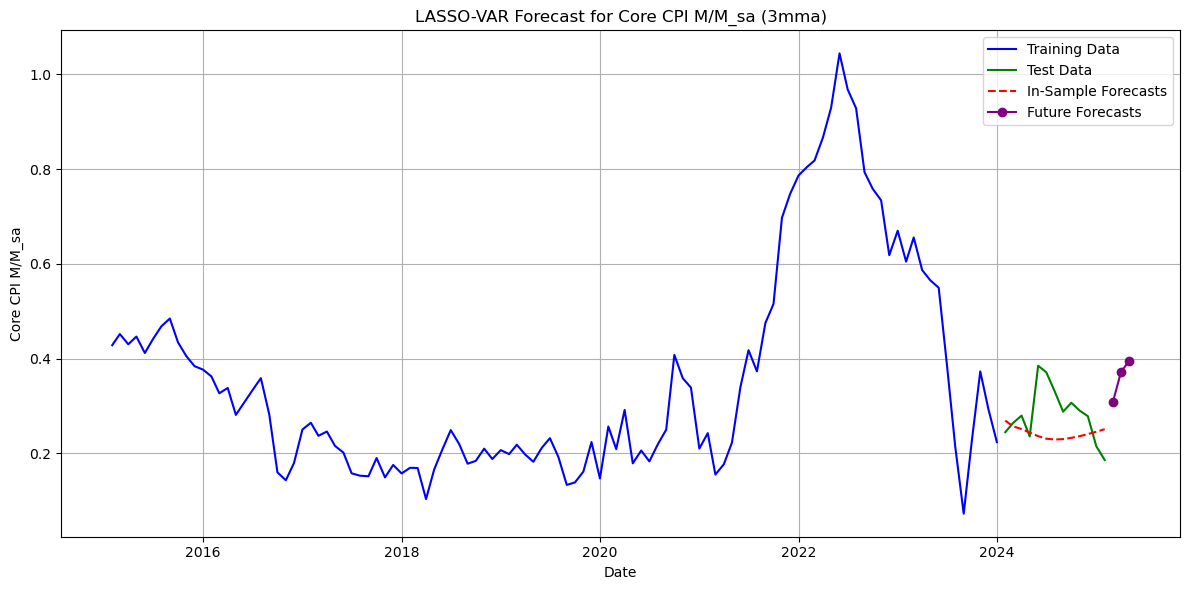

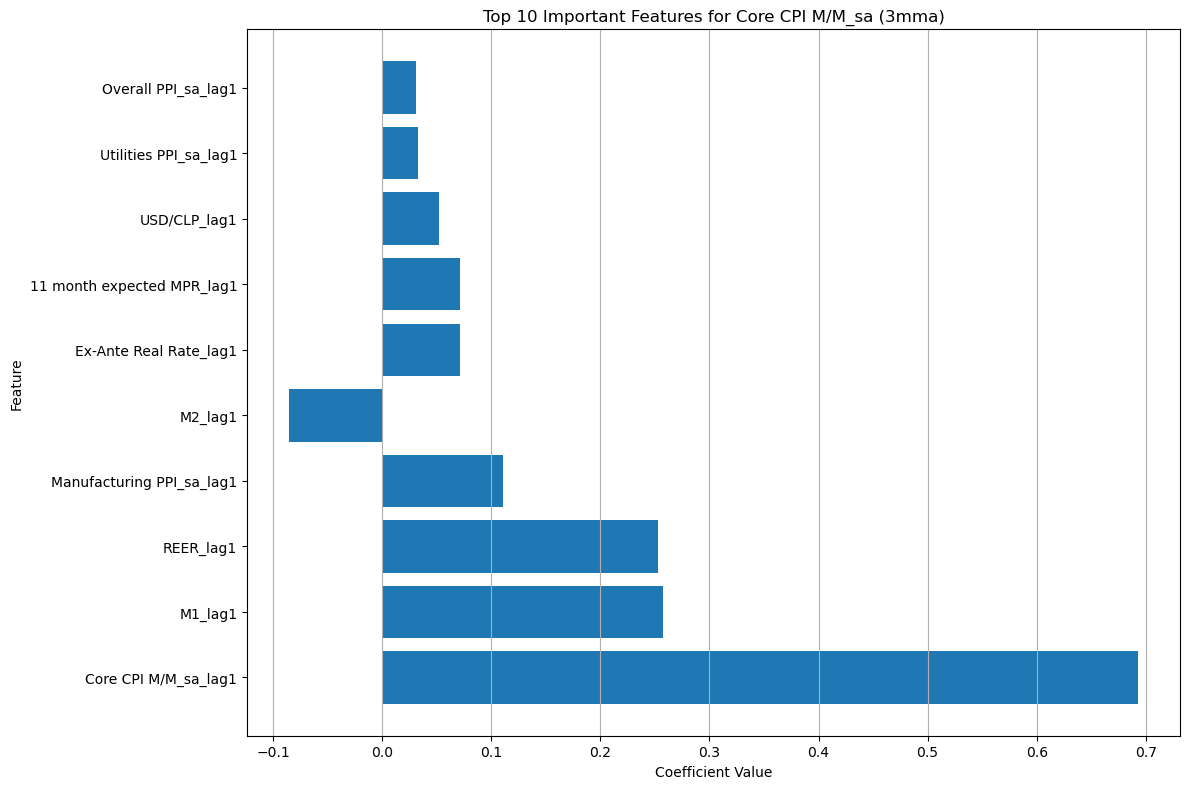


STEP 7: ERROR DECOMPOSITION ANALYSIS

Performing error decomposition to analyze sources of forecast error in test sample...


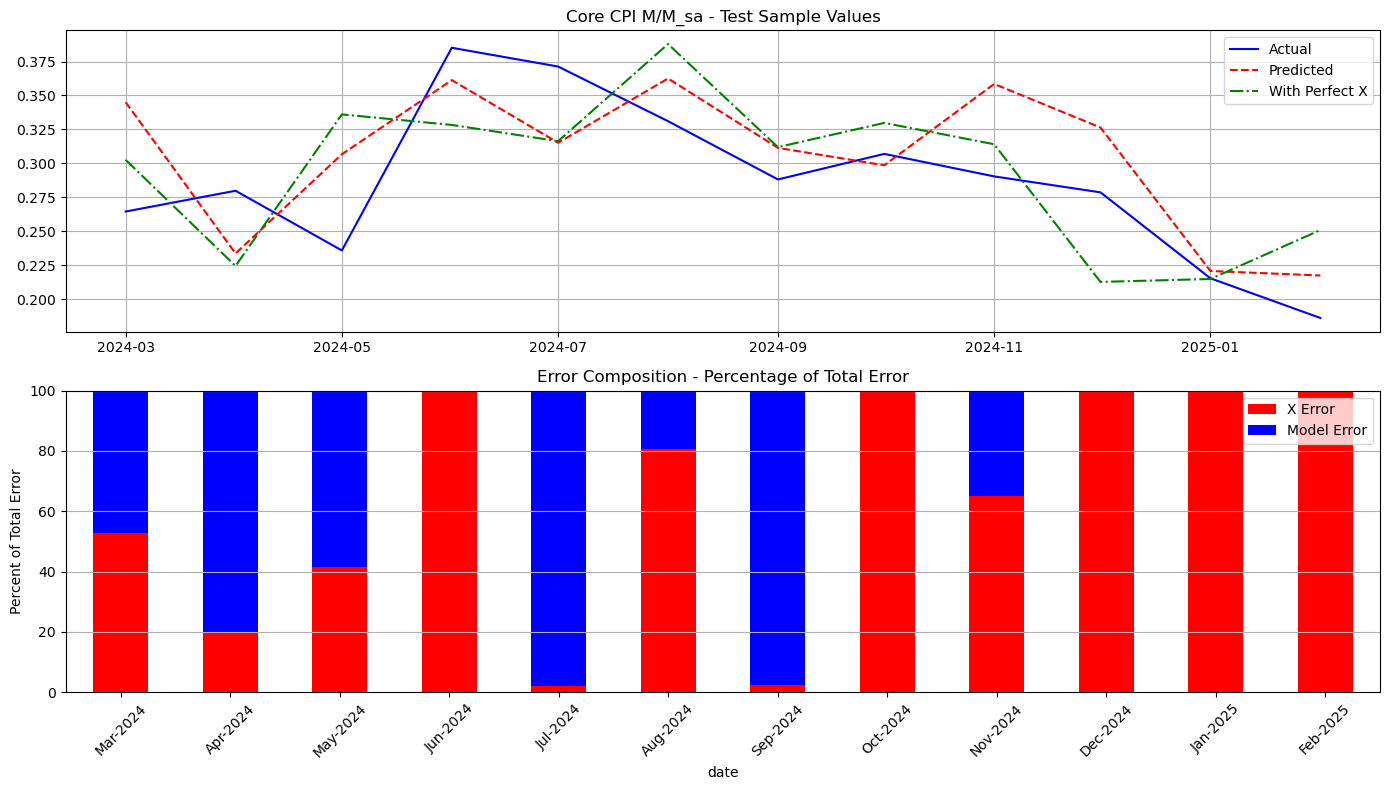

In [4]:
# Main function to run the entire pipeline
def main(file_path='seasonally_adjusted_data2.csv', use_oil_as_exog=True, oil_growth_rate=0.03):
    """
    Run the complete forecasting pipeline with oil price as an exogenous variable
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV data file
    use_oil_as_exog : bool
        Whether to use oil price as an exogenous variable
    oil_growth_rate : float
        Monthly growth rate for oil prices (e.g., 0.03 for 3% growth)
    
    Returns:
    --------
    Various outputs from the forecasting process
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Target variable
    target_var = 'Core CPI M/M_sa'
    
    # Step 1: Load and preprocess data
    df = load_and_preprocess_data(file_path)
    print(f"Loaded data with shape: {df.shape}")
    
    # Extract oil price as exogenous variable if requested
    if use_oil_as_exog and 'Oil Price' in df.columns:
        oil_data = df[['Oil Price']].copy()
        df = df.drop(columns=['Oil Price'])
        print(f"Extracted Oil Price as exogenous variable")
    else:
        oil_data = None
        print(f"Using Oil Price as endogenous variable (if present)")
    
    # Step 2: Normalize features
    normalized_df, scaler, features = normalize_features(df, target_var)
    print(f"Normalized {len(features)} features")
    
    # Also normalize oil data if it exists
    if oil_data is not None:
        oil_scaler = StandardScaler()
        oil_data_normalized = pd.DataFrame(
            oil_scaler.fit_transform(oil_data),
            index=oil_data.index,
            columns=oil_data.columns
        )
        print(f"Normalized Oil Price exogenous variable")
    else:
        oil_data_normalized = None
    
    # Step 3: Check for stationarity and difference non-stationary variables
    stationary_df, stationarity_results, stationary_features = check_and_difference_for_stationarity(
        normalized_df, features, target_var
    )
    
    # Do the same for oil data if it exists
    if oil_data_normalized is not None:
        # Check stationarity of oil price
        oil_feature = oil_data_normalized.columns[0]
        adf_result = adfuller(oil_data_normalized[oil_feature].dropna())
        p_value = adf_result[1]
        is_stationary = p_value < 0.05
        
        print(f"\nOil Price stationarity: {'Stationary' if is_stationary else 'Non-stationary'} (p-value: {p_value:.4f})")
        
        # Difference oil price if non-stationary
        if not is_stationary:
            print(f"Creating differenced Oil Price series")
            oil_data_stationary = pd.DataFrame(
                oil_data_normalized[oil_feature].diff().dropna(),
                columns=[f"{oil_feature}_diff"]
            )
        else:
            oil_data_stationary = oil_data_normalized
        
        # Ensure oil data is aligned with the main dataset
        common_indices = stationary_df.index.intersection(oil_data_stationary.index)
        
        if len(common_indices) < len(stationary_df):
            print(f"Warning: Only {len(common_indices)} out of {len(stationary_df)} dates have matching exogenous data")
            
            # We have two options:
            # 1. Restrict both datasets to common indices
            stationary_df = stationary_df.loc[common_indices]
            oil_data_stationary = oil_data_stationary.loc[common_indices]
            print(f"Restricted datasets to {len(common_indices)} common dates")
            
            # 2. Alternatively, we could interpolate missing oil data, but this might introduce bias
            # oil_data_stationary = oil_data_stationary.reindex(stationary_df.index).interpolate(method='time')
    else:
        oil_data_stationary = None
    
    # Print summary of stationarity results
    print("\nStationarity Test Results:")
    for var, result in stationarity_results.items():
        status = "Stationary" if result['is_stationary'] else "Non-stationary"
        print(f"  - {var}: {status} (p-value: {result['p-value']:.4f})")
    
    # Step 3.5: Create expanded feature set
    expanded_df = create_expanded_features(stationary_df, stationary_features, target_var)
    print(f"Created expanded feature set with shape: {expanded_df.shape}")
    print(f"Total number of features: {expanded_df.shape[1]}")
    
    # If using oil as exogenous, ensure it covers the same date range as expanded_df
    if oil_data_stationary is not None:
        # First check for mismatched date ranges
        if not all(idx in oil_data_stationary.index for idx in expanded_df.index):
            print("Warning: Expanded feature set has dates without matching exogenous data")
            
            # Get common dates
            common_indices = expanded_df.index.intersection(oil_data_stationary.index)
            print(f"Using {len(common_indices)} common dates out of {len(expanded_df)} in feature set")
            
            # Restrict expanded features to dates with matching oil data
            expanded_df = expanded_df.loc[common_indices]
            oil_data_stationary = oil_data_stationary.loc[common_indices]
    
    # Print a breakdown of feature types
    n_original = len(stationary_features) + 1  # +1 for target
    n_lags = n_original * 6
    n_ma = n_original * 3
    n_lagged_ma = n_original * 3 * 6
    print(f"Original features: {n_original}")
    print(f"Lagged features: ~{n_lags}")
    print(f"Moving average features: ~{n_ma}")
    print(f"Lagged moving average features: ~{n_lagged_ma}")
    print(f"Actual total features: {expanded_df.shape[1]}")
    
    # Step 4: Initialize LASSO-VAR model
    model = LassoVAR(max_lags=6, cv=5, max_features=10)
    
    # Step 6: Create forecasts and evaluate with fixed train-test split
    try:
        future_forecasts, metrics, train_data, test_data = plot_forecasts(
            model, expanded_df, 
            exog_data=oil_data_stationary, 
            target_var=target_var, 
            forecast_periods=3,
            oil_growth_rate=oil_growth_rate
        )
        
        # Display train/test split dates
        print(f"\nTrain period: {train_data.index.min()} to {train_data.index.max()}")
        print(f"Test period: {test_data.index.min()} to {test_data.index.max()}")
        
        # Step 5: Analyze feature importance
        importance = analyze_feature_importance(model, target_var, top_n=10)
        
        # Show plots
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error in forecasting pipeline: {str(e)}")
        print("Attempting to run with oil as endogenous variable instead...")
        
        # Try again without exogenous variables
        if oil_data_stationary is not None and use_oil_as_exog:
            # Re-run with oil as endogenous variable
            return main(file_path=file_path, use_oil_as_exog=False, oil_growth_rate=oil_growth_rate)
        else:
            # Something else went wrong
            print("Forecasting pipeline failed")
            return None, None, None, None, None, None, None, None
    
    # Step 7: Decompose forecast errors
    print("\n" + "="*80)
    print("STEP 7: ERROR DECOMPOSITION ANALYSIS")
    print("="*80)

    try:
        print("\nPerforming error decomposition to analyze sources of forecast error in test sample...")
        
        # Call the simplified function that only needs the model and test data
        error_decomposition = decompose_forecast_error(
            model=model, 
            train_data=train_data, 
            test_data=test_data, 
            target_var=target_var
        )
        
        # Add to return values
        return model, future_forecasts, metrics, importance, train_data, test_data, stationarity_results, oil_data_stationary, error_decomposition
    except Exception as e:
        print(f"Error in error decomposition analysis: {str(e)}")
        import traceback
        traceback.print_exc()  # Print full traceback for debugging
        # Return original values plus None for the new return values
        return model, future_forecasts, metrics, importance, train_data, test_data, stationarity_results, oil_data_stationary, None

if __name__ == "__main__":
    # Call with oil as exogenous variable maintaining recent trend
    results = main(use_oil_as_exog=True, oil_growth_rate=0.00)

## Variable Inclusion/Exclusion

Testing impact of 19 variables on forecast accuracy
(Excluding target variable and Core CPI M/M_sa_original)
Running baseline model with all variables...

Checking stationarity of variables...
  - USD/CLP is stationary (p-value: 0.0000).
  - 11 month expected MPR is NOT stationary (p-value: 0.1768). Creating differenced series.
  - Ex-Ante Real Rate is NOT stationary (p-value: 0.1070). Creating differenced series.
  - M1 is NOT stationary (p-value: 0.1900). Creating differenced series.
  - M2 is stationary (p-value: 0.0080).
  - REER is stationary (p-value: 0.0000).
  - Overall PPI_sa is stationary (p-value: 0.0054).
  - Manufacturing PPI_sa is stationary (p-value: 0.0128).
  - Mining PPI_sa is stationary (p-value: 0.0000).
  - Utilities PPI_sa is stationary (p-value: 0.0000).
  - Agri PPI_sa is stationary (p-value: 0.0000).
  - IMACEC Total_sa is stationary (p-value: 0.0040).
  - IMACEC Production of Goods_sa is stationary (p-value: 0.0000).
  - IMACEC Commerce_sa is stationary (p-val

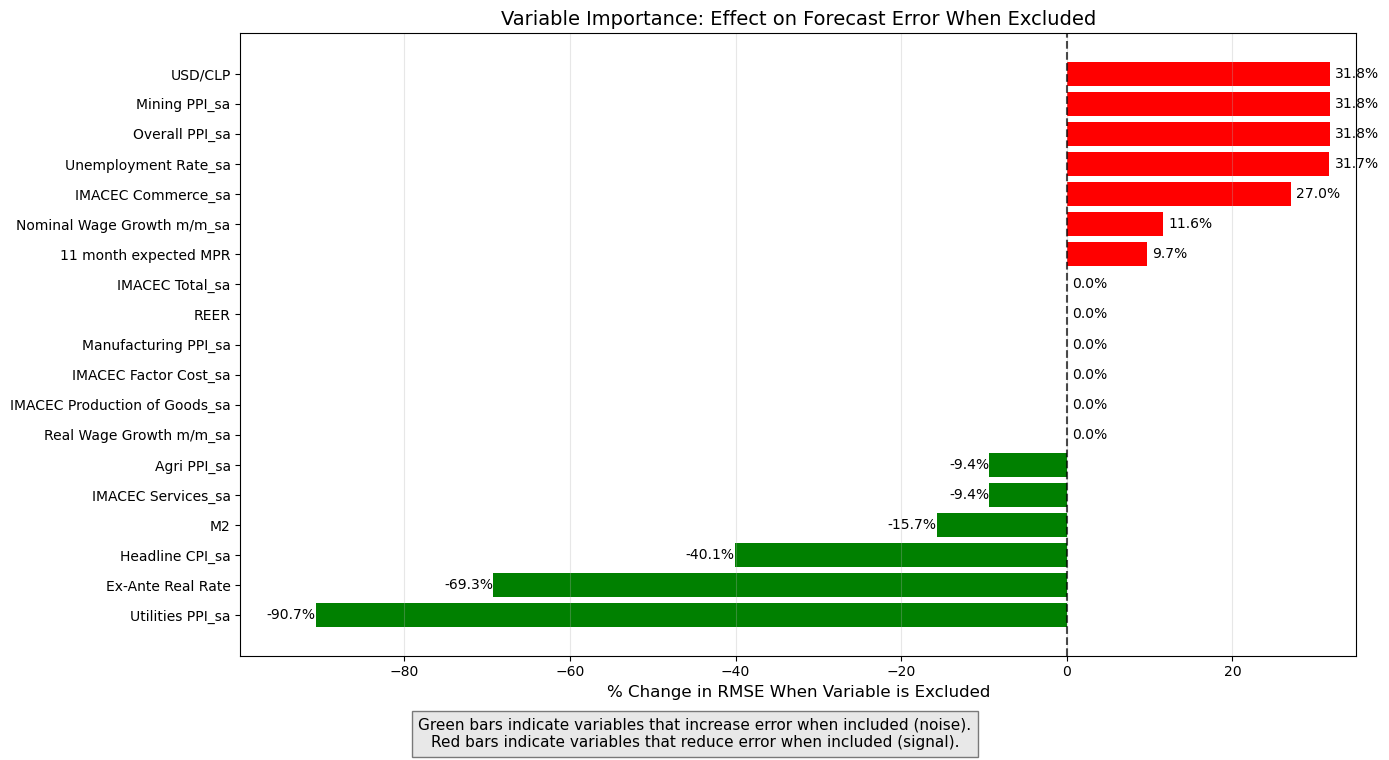

In [265]:
# Variable Inclusion/Exclusion Sensitivity Analysis (Excluding Original CPI)

def variable_inclusion_exclusion_test(data_file='seasonally_adjusted_data2.csv', target_var='Core CPI M/M_sa', use_oil_as_exog=True):
    """
    Test how the inclusion or exclusion of specific variables affects the VAR model
    
    Parameters:
    -----------
    data_file : str
        Path to the CSV data file
    target_var : str
        Target variable to forecast
    use_oil_as_exog : bool
        Whether to use oil price as exogenous variable
        
    Returns:
    --------
    DataFrame with impact of each variable on forecast accuracy
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import warnings
    
    # Suppress warnings and progress output
    warnings.filterwarnings('ignore')
    import sys
    import os
    
    # Suppress printing to keep output clean
    original_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')
    
    # Load and preprocess data
    df = load_and_preprocess_data(data_file)
    
    # Extract oil price as exogenous variable if requested
    if use_oil_as_exog and 'Oil Price' in df.columns:
        oil_data = df[['Oil Price']].copy()
        df = df.drop(columns=['Oil Price'])
    else:
        oil_data = None
    
    original_features = [col for col in df.columns if col != target_var and col != 'Core CPI M/M_sa_original' and col != 'M1' and col != 'Labor Cost m/m_sa']
    
    # Restore stdout to display important messages
    sys.stdout = original_stdout
    print(f"Testing impact of {len(original_features)} variables on forecast accuracy")
    print("(Excluding target variable and Core CPI M/M_sa_original)")
    
    # Run baseline model with all variables
    print("Running baseline model with all variables...")
    baseline_metrics = run_model_and_evaluate(df, oil_data, target_var, use_oil_as_exog)
    baseline_rmse = baseline_metrics['RMSE']
    baseline_mae = baseline_metrics['MAE']
    print(f"Baseline RMSE: {baseline_rmse:.4f}, MAE: {baseline_mae:.4f}")
    
    # Test excluding each variable
    results = []
    
    print("Testing variable exclusions...")
    for i, var_to_exclude in enumerate(original_features):
        print(f"Testing exclusion of variable {i+1}/{len(original_features)}: {var_to_exclude}", end="\r")
        
        # Create dataset without this variable
        reduced_df = df.drop(columns=[var_to_exclude])
        
        # Run model and evaluate
        try:
            # Suppress output during evaluation
            sys.stdout = open(os.devnull, 'w')
            metrics = run_model_and_evaluate(reduced_df, oil_data, target_var, use_oil_as_exog)
            sys.stdout = original_stdout
            
            rmse = metrics['RMSE']
            mae = metrics['MAE']
            
            # Calculate impact
            rmse_change = rmse - baseline_rmse
            rmse_change_pct = (rmse - baseline_rmse) / baseline_rmse * 100
            mae_change = mae - baseline_mae
            mae_change_pct = (mae - baseline_mae) / baseline_mae * 100
            
            # Store results
            results.append({
                'variable': var_to_exclude,
                'rmse': rmse,
                'mae': mae,
                'rmse_change': rmse_change,
                'rmse_change_pct': rmse_change_pct,
                'mae_change': mae_change,
                'mae_change_pct': mae_change_pct,
                'impact': 'Negative' if rmse_change > 0 else 'Positive'
            })
        except Exception as e:
            sys.stdout = original_stdout
            print(f"Error testing exclusion of {var_to_exclude}: {str(e)}")
    
    # Make sure stdout is restored
    sys.stdout = original_stdout
    print("\nCompleted variable exclusion tests")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Add baseline for reference
    baseline_row = {
        'variable': 'BASELINE (All Variables)',
        'rmse': baseline_rmse,
        'mae': baseline_mae,
        'rmse_change': 0,
        'rmse_change_pct': 0,
        'mae_change': 0,
        'mae_change_pct': 0,
        'impact': 'Neutral'
    }
    results_df = pd.concat([pd.DataFrame([baseline_row]), results_df], ignore_index=True)
    
    # Sort by RMSE percent change
    results_df = results_df.sort_values('rmse_change_pct', ascending=True)
    
    # Display results
    print("\nVariable Exclusion Impact Results (sorted by impact):")
    pd.set_option('display.max_rows', None)  # Show all rows
    print(results_df[['variable', 'rmse', 'rmse_change', 'rmse_change_pct', 'impact']])
    
    # Create visualization (with improved label placement)
    plt.figure(figsize=(14, 8))  # Make the figure wider to accommodate labels

    # Select variables to display (skip baseline)
    plot_df = results_df[results_df['variable'] != 'BASELINE (All Variables)'].copy()

    # Sort for better visualization (most negative impact first)
    plot_df = plot_df.sort_values('rmse_change_pct')

    # Set colors based on impact
    colors = ['green' if x < 0 else 'red' for x in plot_df['rmse_change_pct']]

    # Create bar plot
    bars = plt.barh(plot_df['variable'], plot_df['rmse_change_pct'], color=colors)

    # Add baseline reference line
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)

    # Add labels and title
    plt.xlabel('% Change in RMSE When Variable is Excluded', fontsize=12)
    plt.title('Variable Importance: Effect on Forecast Error When Excluded', fontsize=14)

    # Set y-axis limits to create more space
    plt.xlim(min(plot_df['rmse_change_pct']) * 1.1, max(plot_df['rmse_change_pct']) * 1.1)  # Add 10% padding

    # Add text annotations with improved positioning
    for i, bar in enumerate(bars):
        width = bar.get_width()
        if width < 0:
            # For green bars (negative values) - position text farther to the left
            x_pos = width * 1  # Move 5% further left
            text = f"{width:.1f}%"
            ha = 'right'
            color = 'black'
            fontweight = 'normal'
        else:
            # For red bars (positive values)
            x_pos = width + max(plot_df['rmse_change_pct']) * 0.02  # Position right with some padding
            text = f"{width:.1f}%"
            ha = 'left'
            color = 'black'
            fontweight = 'normal'
        
        plt.text(x_pos, bar.get_y() + bar.get_height()/2, text, 
                ha=ha, va='center', color=color, fontweight=fontweight)

    # Add explanatory note
    plt.figtext(0.5, 0.01, 
                "Green bars indicate variables that increase error when included (noise).\n"
                "Red bars indicate variables that reduce error when included (signal).", 
                ha="center", fontsize=11, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Make room for the note
    plt.show()
    
    return results_df


def run_model_and_evaluate(data, oil_data, target_var, use_oil_as_exog):
    """
    Run the VAR model with given data and evaluate forecast accuracy
    
    Parameters:
    -----------
    data : pandas DataFrame
        Dataset for model (possibly with a variable excluded)
    oil_data : pandas DataFrame or None
        Oil price data if used as exogenous
    target_var : str
        Target variable to forecast
    use_oil_as_exog : bool
        Whether to use oil as exogenous
        
    Returns:
    --------
    Dictionary with evaluation metrics
    """
    from sklearn.preprocessing import StandardScaler
    from statsmodels.tsa.stattools import adfuller
    import warnings
    
    # Suppress warnings
    warnings.filterwarnings('ignore')
    
    # Normalize features
    normalized_df, scaler, features = normalize_features(data, target_var)
    
    # Also normalize oil data if it exists
    if oil_data is not None and use_oil_as_exog:
        oil_scaler = StandardScaler()
        oil_data_normalized = pd.DataFrame(
            oil_scaler.fit_transform(oil_data),
            index=oil_data.index,
            columns=oil_data.columns
        )
    else:
        oil_data_normalized = None
    
    # Check for stationarity and difference non-stationary variables
    stationary_df, stationarity_results, stationary_features = check_and_difference_for_stationarity(
        normalized_df, features, target_var
    )
    
    # Do the same for oil data if it exists
    if oil_data_normalized is not None:
        # Check stationarity of oil price
        oil_feature = oil_data_normalized.columns[0]
        adf_result = adfuller(oil_data_normalized[oil_feature].dropna())
        p_value = adf_result[1]
        is_stationary = p_value < 0.05
        
        # Difference oil price if non-stationary
        if not is_stationary:
            oil_data_stationary = pd.DataFrame(
                oil_data_normalized[oil_feature].diff().dropna(),
                columns=[f"{oil_feature}_diff"]
            )
        else:
            oil_data_stationary = oil_data_normalized
        
        # Ensure oil data is aligned with the main dataset
        common_indices = stationary_df.index.intersection(oil_data_stationary.index)
        
        if len(common_indices) < len(stationary_df):
            # Restrict both datasets to common indices
            stationary_df = stationary_df.loc[common_indices]
            oil_data_stationary = oil_data_stationary.loc[common_indices]
    else:
        oil_data_stationary = None
    
    # Create expanded feature set
    expanded_df = create_expanded_features(stationary_df, stationary_features, target_var, 
                                         max_lag=4, max_ma=2)  # Simplified parameters for faster execution
    
    # If using oil as exogenous, ensure it covers the same date range as expanded_df
    if oil_data_stationary is not None:
        # Get common dates
        common_indices = expanded_df.index.intersection(oil_data_stationary.index)
        
        # Restrict expanded features to dates with matching oil data
        expanded_df = expanded_df.loc[common_indices]
        oil_data_stationary = oil_data_stationary.loc[common_indices]
    
    # Fixed train-test split (80/20)
    train_size = 0.8
    train_idx = int(len(expanded_df) * train_size)
    train_data = expanded_df.iloc[:train_idx]
    test_data = expanded_df.iloc[train_idx:]
    
    # Initialize LASSO-VAR model (simplified parameters)
    model = LassoVAR(max_lags=4, cv=3, max_features=10)
    
    # Handle exogenous data if provided
    if oil_data_stationary is not None:
        # Split exogenous data
        train_exog = oil_data_stationary.loc[oil_data_stationary.index.isin(train_data.index)]
        test_exog = oil_data_stationary.loc[oil_data_stationary.index.isin(test_data.index)]
        
        # Ensure perfect alignment
        common_indices = train_data.index.intersection(train_exog.index)
        train_data = train_data.loc[common_indices]
        train_exog = train_exog.loc[common_indices]
        
        # Fit model with exogenous variables
        try:
            model.fit_with_exog(train_data, train_exog)
            
            # Get last exogenous value
            last_exog_value = train_exog.iloc[-1]
            
            # Generate future exogenous values for test period
            future_test_exog = model.generate_future_exog(
                last_exog_value,
                steps=len(test_data),
                growth_rates=0.03  # Fixed 3% growth
            )
            
            # Generate forecasts
            forecasts = model.predict_with_exog(
                train_data,
                exog=train_exog,
                future_exog=future_test_exog,
                steps=len(test_data)
            )
        except Exception as e:
            # Fallback to standard fit
            model.fit(train_data)
            forecasts = model.predict(train_data, steps=len(test_data))
    else:
        # Standard fit without exogenous
        model.fit(train_data)
        forecasts = model.predict(train_data, steps=len(test_data))
    
    # Ensure forecasts and test_data are aligned
    if len(forecasts) > len(test_data):
        forecasts = forecasts.iloc[:len(test_data)]
    
    # Calculate error metrics
    if target_var in forecasts.columns:
        forecast_values = forecasts[target_var]
    else:
        forecast_values = forecasts.iloc[:, 0]  # Assume first column
        
    actual_values = test_data[target_var]
    
    # Ensure alignment
    common_idx = forecast_values.index.intersection(actual_values.index)
    forecast_values = forecast_values.loc[common_idx]
    actual_values = actual_values.loc[common_idx]
    
    # Calculate errors
    errors = actual_values - forecast_values
    rmse = np.sqrt((errors ** 2).mean())
    mae = errors.abs().mean()
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'errors': errors
    }

# Run the variable inclusion/exclusion test
if __name__ == "__main__":
    # This can be in a new cell in your notebook
    # Run the variable sensitivity analysis
    results = variable_inclusion_exclusion_test('seasonally_adjusted_data2.csv', use_oil_as_exog=True)
    
    # Save results to CSV for later analysis
    results.to_csv('variable_exclusion_results.csv', index=False)

## Hyperparameter Tuning (needs a CPU to run - best to not activate)

In [ ]:
# Hyperparameter Optimization for VAR Model (Sequential Version)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import itertools
from tqdm import tqdm
import seaborn as sns

# Define evaluate_params as a standalone function (not nested)
def evaluate_single_param_set(params, data_file, target_var='Core CPI M/M_sa', use_oil_as_exog=True):
    """
    Evaluate a single set of hyperparameters
    """
    try:
        # Extract parameters
        max_lags = params['max_lags']
        max_features = params['max_features']
        train_size = params['train_size']
        oil_growth_rate = params.get('oil_growth_rate', 0.03)  # Default to 3%
        
        # Load and preprocess data
        df = load_and_preprocess_data(data_file)
        
        # Extract oil price as exogenous variable if requested
        if use_oil_as_exog and 'Oil Price' in df.columns:
            oil_data = df[['Oil Price']].copy()
            df = df.drop(columns=['Oil Price'])
        else:
            oil_data = None
        
        # Normalize features
        normalized_df, scaler, features = normalize_features(df, target_var)
        
        # Also normalize oil data if it exists
        if oil_data is not None:
            from sklearn.preprocessing import StandardScaler
            oil_scaler = StandardScaler()
            oil_data_normalized = pd.DataFrame(
                oil_scaler.fit_transform(oil_data),
                index=oil_data.index,
                columns=oil_data.columns
            )
        else:
            oil_data_normalized = None
        
        # Check for stationarity and difference non-stationary variables
        stationary_df, stationarity_results, stationary_features = check_and_difference_for_stationarity(
            normalized_df, features, target_var
        )
        
        # Do the same for oil data if it exists
        if oil_data_normalized is not None:
            from statsmodels.tsa.stattools import adfuller
            # Check stationarity of oil price
            oil_feature = oil_data_normalized.columns[0]
            adf_result = adfuller(oil_data_normalized[oil_feature].dropna())
            p_value = adf_result[1]
            is_stationary = p_value < 0.05
            
            # Difference oil price if non-stationary
            if not is_stationary:
                oil_data_stationary = pd.DataFrame(
                    oil_data_normalized[oil_feature].diff().dropna(),
                    columns=[f"{oil_feature}_diff"]
                )
            else:
                oil_data_stationary = oil_data_normalized
            
            # Ensure oil data is aligned with the main dataset
            common_indices = stationary_df.index.intersection(oil_data_stationary.index)
            
            if len(common_indices) < len(stationary_df):
                # Restrict both datasets to common indices
                stationary_df = stationary_df.loc[common_indices]
                oil_data_stationary = oil_data_stationary.loc[common_indices]
        else:
            oil_data_stationary = None
        
        # Create expanded feature set
        expanded_df = create_expanded_features(stationary_df, stationary_features, target_var)
        
        # If using oil as exogenous, ensure it covers the same date range as expanded_df
        if oil_data_stationary is not None:
            # Get common dates
            common_indices = expanded_df.index.intersection(oil_data_stationary.index)
            
            # Restrict expanded features to dates with matching oil data
            expanded_df = expanded_df.loc[common_indices]
            oil_data_stationary = oil_data_stationary.loc[common_indices]
        
        # Custom fixed train-test split
        train_idx = int(len(expanded_df) * train_size)
        train_data = expanded_df.iloc[:train_idx]
        test_data = expanded_df.iloc[train_idx:]
        
        # Initialize LASSO-VAR model with current hyperparameters
        model = LassoVAR(max_lags=max_lags, cv=5, max_features=max_features)
        
        # Handle exogenous data if provided
        if oil_data_stationary is not None:
            # Split exogenous data and ensure index alignment with train/test data
            train_exog = oil_data_stationary.loc[oil_data_stationary.index.isin(train_data.index)].copy()
            test_exog = oil_data_stationary.loc[oil_data_stationary.index.isin(test_data.index)].copy()
            
            # Make sure we have matching indices
            if len(train_exog) != len(train_data):
                # Get common indices
                common_indices = train_data.index.intersection(train_exog.index)
                
                # Restrict data to common indices
                train_data = train_data.loc[common_indices]
                train_exog = train_exog.loc[common_indices]
            
            # Fit model with exogenous variables
            try:
                model.fit_with_exog(train_data, train_exog)
            except Exception as e:
                # Fallback to standard fit without exogenous variables
                model.fit(train_data)
                oil_data_stationary = None
                train_exog = None
                test_exog = None
            
            if oil_data_stationary is not None:  # Continue only if we didn't fallback
                # Get last observed exogenous value for generating future values
                last_exog_value = train_exog.iloc[-1]
                
                # Generate future exogenous values for test period
                future_test_exog = model.generate_future_exog(
                    last_exog_value,
                    steps=len(test_data),
                    growth_rates=oil_growth_rate
                )
                
                # Generate forecasts for test period
                test_forecasts = model.predict_with_exog(
                    train_data,
                    exog=train_exog,
                    future_exog=future_test_exog,
                    steps=len(test_data)
                )
            else:
                # Standard forecasting (after fallback)
                test_forecasts = model.predict(train_data, steps=len(test_data))
        else:
            # Standard fitting and forecasting without exogenous variables
            model.fit(train_data)
            test_forecasts = model.predict(train_data, steps=len(test_data))
        
        # Ensure test_forecasts and test_data are aligned
        if len(test_forecasts) > len(test_data):
            test_forecasts = test_forecasts.iloc[:len(test_data)]
        
        # Calculate error metrics
        if target_var in test_forecasts.columns:
            forecast_values = test_forecasts[target_var]
        else:
            forecast_values = test_forecasts.iloc[:, 0]  # Assume first column
            
        actual_values = test_data[target_var]
        
        # Make sure indexes match
        common_idx = forecast_values.index.intersection(actual_values.index)
        forecast_values = forecast_values.loc[common_idx]
        actual_values = actual_values.loc[common_idx]
        
        # Calculate errors
        errors = actual_values - forecast_values
        mae = errors.abs().mean()
        mse = (errors ** 2).mean()
        rmse = np.sqrt(mse)
        
        # Return results
        result = {
            'max_lags': max_lags,
            'max_features': max_features,
            'train_size': train_size,
            'oil_growth_rate': oil_growth_rate,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'train_start': train_data.index.min(),
            'train_end': train_data.index.max(),
            'test_start': test_data.index.min(),
            'test_end': test_data.index.max(),
            'n_train': len(train_data),
            'n_test': len(test_data)
        }
            
        return result
    
    except Exception as e:
        # Return error info
        error_result = {
            'max_lags': params.get('max_lags', None),
            'max_features': params.get('max_features', None),
            'train_size': params.get('train_size', None),
            'oil_growth_rate': params.get('oil_growth_rate', 0.03),
            'error': str(e)
        }
            
        return error_result

def hyperparameter_grid_search(data_file, target_var='Core CPI M/M_sa', use_oil_as_exog=True, oil_growth_rate=0.03):
    """
    Perform grid search over multiple hyperparameters for the VAR model.
    Sequential version without multiprocessing.
    
    Parameters:
    -----------
    data_file : str
        Path to the CSV data file
    target_var : str
        Target variable to forecast
    use_oil_as_exog : bool
        Whether to use oil price as exogenous variable
    oil_growth_rate : float
        Fixed oil growth rate to use (not varied in grid search)
        
    Returns:
    --------
    DataFrame with hyperparameter performance results
    """
    # Define hyperparameter grid
    param_grid = {
        'max_lags': [2, 4, 6, 8],  # Different lag structures
        'max_features': [5, 10, 15, 20],  # Number of features selected
        'train_size': [0.7, 0.8, 0.9]  # Different train-test splits
    }
    
    # Generate all combinations of hyperparameters
    param_combinations = []
    for max_lags, max_features, train_size in itertools.product(
        param_grid['max_lags'], 
        param_grid['max_features'], 
        param_grid['train_size']):
        param_combinations.append({
            'max_lags': max_lags,
            'max_features': max_features,
            'train_size': train_size,
            'oil_growth_rate': oil_growth_rate  # Fixed value, not varied
        })
    
    print(f"Testing {len(param_combinations)} hyperparameter combinations")
    print("Running sequentially (this may take some time)...")
    
    # Run sequential processing
    results = []
    for params in tqdm(param_combinations):
        try:
            result = evaluate_single_param_set(params, data_file, target_var, use_oil_as_exog)
            results.append(result)
            
            # Print intermediate results for better progress tracking
            if 'RMSE' in result:
                print(f"Params: {params}, RMSE: {result['RMSE']:.4f}")
            else:
                print(f"Error with params: {params}")
        except Exception as e:
            print(f"Error evaluating params {params}: {str(e)}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by RMSE
    if 'RMSE' in results_df.columns and not results_df['RMSE'].isna().all():
        results_df = results_df.sort_values('RMSE')
    
    return results_df

def visualize_hyperparameter_results(results_df):
    """
    Visualize the results of hyperparameter optimization
    
    Parameters:
    -----------
    results_df : pandas DataFrame
        Results from hyperparameter grid search
    """
    # Check if we have valid results
    if 'RMSE' not in results_df.columns or results_df['RMSE'].isna().all():
        print("No valid results to visualize")
        return None
    
    # Drop rows with errors
    if 'error' in results_df.columns:
        valid_results = results_df[results_df['error'].isna()].copy()
    else:
        valid_results = results_df.copy()
    
    if len(valid_results) == 0:
        print("No valid results after filtering errors")
        return None
    
    # 1. Plot the distribution of RMSE values
    plt.figure(figsize=(10, 6))
    plt.hist(valid_results['RMSE'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of RMSE Values')
    plt.xlabel('RMSE')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 2. Create heatmaps for key hyperparameter pairs
    
    # max_lags vs max_features
    try:
        pivot_lags_features = valid_results.pivot_table(
            values='RMSE', 
            index='max_lags', 
            columns='max_features',
            aggfunc='mean'
        )
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(pivot_lags_features, annot=True, cmap='viridis_r', fmt='.4f')
        plt.title('RMSE by max_lags and max_features')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error creating lags vs features heatmap: {str(e)}")
    
    # max_lags vs train_size
    try:
        pivot_lags_train = valid_results.pivot_table(
            values='RMSE', 
            index='max_lags', 
            columns='train_size',
            aggfunc='mean'
        )
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(pivot_lags_train, annot=True, cmap='viridis_r', fmt='.4f')
        plt.title('RMSE by max_lags and train_size')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error creating lags vs train_size heatmap: {str(e)}")
    
    # max_features vs train_size
    try:
        pivot_features_train = valid_results.pivot_table(
            values='RMSE', 
            index='max_features', 
            columns='train_size',
            aggfunc='mean'
        )
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(pivot_features_train, annot=True, cmap='viridis_r', fmt='.4f')
        plt.title('RMSE by max_features and train_size')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error creating features vs train_size heatmap: {str(e)}")
    
    # 3. Plot parameter importance
    # Compute average RMSE for each hyperparameter value
    param_importance = {}
    
    # For each hyperparameter, calculate mean RMSE for each value
    for param in ['max_lags', 'max_features', 'train_size']:
        if param in valid_results.columns:
            try:
                grouped = valid_results.groupby(param)['RMSE'].mean().reset_index()
                param_importance[param] = grouped
                
                # Plot
                plt.figure(figsize=(10, 6))
                plt.plot(grouped[param], grouped['RMSE'], marker='o', linestyle='-')
                plt.title(f'Average RMSE by {param}')
                plt.xlabel(param)
                plt.ylabel('Average RMSE')
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error creating {param} importance plot: {str(e)}")
    
    # 4. Display best parameter combinations
    print("\nTop 5 Parameter Combinations:")
    display(valid_results.head(5))
    
    return valid_results.head(5)

def run_best_model(best_params, data_file, target_var='Core CPI M/M_sa', use_oil_as_exog=True, oil_growth_rate=0.03):
    """
    Run the model with the best hyperparameters and generate forecasts
    
    Parameters:
    -----------
    best_params : dict
        Best hyperparameters from grid search
    data_file : str
        Path to the CSV data file
    target_var : str
        Target variable to forecast
    use_oil_as_exog : bool
        Whether to use oil price as exogenous variable
    oil_growth_rate : float
        Fixed oil growth rate to use
        
    Returns:
    --------
    Model and forecast results
    """
    # Extract parameters
    max_lags = best_params['max_lags']
    max_features = best_params['max_features']
    train_size = best_params.get('train_size', 0.9)  # Default to 0.9 if not provided
    
    print(f"Running best model with parameters:")
    print(f"  max_lags: {max_lags}")
    print(f"  max_features: {max_features}")
    print(f"  train_size: {train_size}")
    print(f"  oil_growth_rate: {oil_growth_rate} (fixed)")
    
    # Load and preprocess data
    df = load_and_preprocess_data(data_file)
    
    # Process similar to the main function but with best hyperparameters
    # Extract oil price as exogenous variable if requested
    if use_oil_as_exog and 'Oil Price' in df.columns:
        oil_data = df[['Oil Price']].copy()
        df = df.drop(columns=['Oil Price'])
    else:
        oil_data = None
    
    # Normalize features
    normalized_df, scaler, features = normalize_features(df, target_var)
    
    # Also normalize oil data if it exists
    if oil_data is not None:
        from sklearn.preprocessing import StandardScaler
        oil_scaler = StandardScaler()
        oil_data_normalized = pd.DataFrame(
            oil_scaler.fit_transform(oil_data),
            index=oil_data.index,
            columns=oil_data.columns
        )
    else:
        oil_data_normalized = None
    
    # Check for stationarity and difference non-stationary variables
    stationary_df, stationarity_results, stationary_features = check_and_difference_for_stationarity(
        normalized_df, features, target_var
    )
    
    # Do the same for oil data if it exists
    if oil_data_normalized is not None:
        from statsmodels.tsa.stattools import adfuller
        # Check stationarity of oil price
        oil_feature = oil_data_normalized.columns[0]
        adf_result = adfuller(oil_data_normalized[oil_feature].dropna())
        p_value = adf_result[1]
        is_stationary = p_value < 0.05
        
        # Difference oil price if non-stationary
        if not is_stationary:
            oil_data_stationary = pd.DataFrame(
                oil_data_normalized[oil_feature].diff().dropna(),
                columns=[f"{oil_feature}_diff"]
            )
        else:
            oil_data_stationary = oil_data_normalized
        
        # Ensure oil data is aligned with the main dataset
        common_indices = stationary_df.index.intersection(oil_data_stationary.index)
        
        if len(common_indices) < len(stationary_df):
            # Restrict both datasets to common indices
            stationary_df = stationary_df.loc[common_indices]
            oil_data_stationary = oil_data_stationary.loc[common_indices]
    else:
        oil_data_stationary = None
    
    # Create expanded feature set
    expanded_df = create_expanded_features(stationary_df, stationary_features, target_var)
    
    # If using oil as exogenous, ensure it covers the same date range as expanded_df
    if oil_data_stationary is not None:
        # Get common dates
        common_indices = expanded_df.index.intersection(oil_data_stationary.index)
        
        # Restrict expanded features to dates with matching oil data
        expanded_df = expanded_df.loc[common_indices]
        oil_data_stationary = oil_data_stationary.loc[common_indices]
    
    # Custom fixed train-test split based on best hyperparameters
    train_idx = int(len(expanded_df) * train_size)
    train_data = expanded_df.iloc[:train_idx]
    test_data = expanded_df.iloc[train_idx:]
    
    # Initialize LASSO-VAR model with best hyperparameters
    model = LassoVAR(max_lags=max_lags, cv=5, max_features=max_features)
    
    # Run plot_forecasts with best model and hyperparameters
    future_forecasts, metrics, train_data, test_data = plot_forecasts(
        model, 
        expanded_df, 
        exog_data=oil_data_stationary, 
        target_var=target_var, 
        forecast_periods=6,  # Extend to 6 months
        oil_growth_rate=oil_growth_rate
    )
    
    # Display train/test split dates
    print(f"\nTrain period: {train_data.index.min()} to {train_data.index.max()}")
    print(f"Test period: {test_data.index.min()} to {test_data.index.max()}")
    
    # Analyze feature importance
    importance = analyze_feature_importance(model, target_var, top_n=20)  # Increase to 20 features
    
    # Run error decomposition
    try:
        print("\nPerforming error decomposition with best model...")
        error_decomposition = decompose_forecast_error(
            model=model, 
            train_data=train_data, 
            test_data=test_data, 
            target_var=target_var
        )
    except Exception as e:
        print(f"Error in error decomposition analysis: {str(e)}")
        error_decomposition = None
    
    return model, future_forecasts, metrics, importance, train_data, test_data, error_decomposition

In [ ]:
# Run hyperparameter optimization (sequential version)
results_df = hyperparameter_grid_search(
    'seasonally_adjusted_data2.csv', 
    use_oil_as_exog=True, 
    oil_growth_rate=0.03  # Fixed at 3%
)

# Save results to CSV
results_df.to_csv('hyperparameter_results.csv', index=False)

# Visualize results
best_params = visualize_hyperparameter_results(results_df)

# Run the model with the best parameters
if isinstance(best_params, pd.DataFrame) and len(best_params) > 0:
    best_params = best_params.iloc[0].to_dict()
    
    # Run best model
    best_model_results = run_best_model(
        best_params, 
        'seasonally_adjusted_data2.csv', 
        use_oil_as_exog=True,
        oil_growth_rate=0.03  # Keep the fixed oil growth rate
    )
